## 1. Import Relevant Packages

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
import statsmodels.api as sm

## 2. Query CRSP Database

In [2]:
# Stocks are from NYSE, AMEX and NASDAQ (exchcd = 1,2,3)
# We use monthly return data from common stocks (share code 10 and 11)

In [3]:
# Loading stocks
crsp_input = pd.read_csv('Stocks1926.csv', low_memory=False)

In [4]:
# Make all column names lower case
crsp_input.columns = crsp_input.columns.str.lower()

In [5]:
# Set datetime format
crsp_input['date'] =  pd.to_datetime(crsp_input['date'])
crsp_input['dlpdt'] =  pd.to_datetime(crsp_input['dlpdt'])
crsp_input

,permno,date,shrcd,exchcd,siccd,dlpdt,dlret,prc,ret,shrout
0,10000,1986-01-31,10,3,3990,NaT,NaN,-4.37500,C,3680.0
1,10000,1986-02-28,10,3,3990,NaT,NaN,-3.25000,-0.257143,3680.0
2,10000,1986-03-31,10,3,3990,NaT,NaN,-4.43750,0.365385,3680.0
3,10000,1986-04-30,10,3,3990,NaT,NaN,-4.00000,-0.098592,3793.0
4,10000,1986-05-30,10,3,3990,NaT,NaN,-3.10938,-0.222656,3793.0
...,...,...,...,...,...,...,...,...,...,...
3630351,93436,2020-08-31,11,3,9999,NaT,NaN,498.32001,0.741452,931809.0
3630352,93436,2020-09-30,11,3,9999,NaT,NaN,429.01001,-0.139087,948000.0
3630353,93436,2020-10-30,11,3,9999,NaT,NaN,388.04001,-0.095499,947901.0
3630354,93436,2020-11-30,11,3,9999,NaT,NaN,567.59998,0.462736,947901.0


In [6]:
crsp_input.describe()

,permno,shrcd,exchcd,prc,shrout
count,3.630356e+06,3.630356e+06,3.630356e+06,3.589544e+06,3.626644e+06
mean,5.008963e+04,1.073109e+01,2.129488e+00,2.838403e+01,4.220043e+04
std,2.822151e+04,4.433946e-01,9.282416e-01,1.479372e+03,2.423731e+05
min,1.000000e+04,1.000000e+01,1.000000e+00,-1.832500e+03,0.000000e+00
25%,2.165300e+04,1.000000e+01,1.000000e+00,1.750000e+00,2.214000e+03
50%,4.913800e+04,1.100000e+01,3.000000e+00,1.087500e+01,6.984000e+03
75%,7.874900e+04,1.100000e+01,3.000000e+00,2.549000e+01,2.419200e+04
max,9.343600e+04,1.100000e+01,3.000000e+00,3.478150e+05,2.920640e+07


In [7]:
# Make Python datetime format
crsp_input['date'] =  pd.to_datetime(crsp_input['date'])

#Make end of month (non-trading days)
crsp_input['date'] = crsp_input['date']+MonthEnd(0)

# Sample starts in 1926
crsp_file = crsp_input[crsp_input['date'] >= '1926-01-31']

In [8]:
# Change variable format to int
crsp_file[['permno','shrcd','exchcd']]=\
    crsp_file[['permno','shrcd','exchcd']].astype(int)

In [9]:
# Forcing errors to become NaN to convert to int
crsp_file['ret'] = pd.to_numeric(crsp_file['ret'], errors='coerce')
crsp_file['dlret'] = pd.to_numeric(crsp_file['dlret'], errors='coerce') 

In [10]:
# Fill-in delisting return as last return
crsp_file['ret'] = crsp_file['ret'].fillna(value=crsp_file['dlret'])

# Dropping NaNs
crsp_m = crsp_file[crsp_file['ret'].notna()]

In [11]:
# If a stock is delisted on the first day of a given month t, we could not invest in month t
# Our stock universe at month t consists of the top 500 stock based on market cap for the previous month (t-1)
# Therefore, we set the price (i.e. market cap) to 0 in month (t-1) if the stock is delisted in beginning of month t
crsp_m['prc'] = np.where(crsp_m['dlpdt'] == crsp_m['date']+MonthBegin(1), 0, crsp_m['prc'])

<ipython-input-11-67f09a80a21b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crsp_m['prc'] = np.where(crsp_m['dlpdt'] == crsp_m['date']+MonthBegin(1), 0, crsp_m['prc'])


In [12]:
# Loading stocks with missing values
missing_stocks = pd.read_csv('missing_values.csv', names=['permno', 'delist_date'], header=0)
missing_stocks

missing_stocks['delist_date'] =  pd.to_datetime(missing_stocks['delist_date'])

# Making date column one day before delisting date
missing_stocks['date']=missing_stocks['delist_date']-MonthEnd(1)
missing_stocks

,permno,delist_date,date
0,24096,1965-12-31,1965-11-30
1,10866,1966-04-30,1966-03-31
2,37540,1966-06-30,1966-05-31
3,37196,1966-08-31,1966-07-31
4,10591,1967-07-31,1967-06-30
...,...,...,...
120,13567,2016-05-31,2016-04-30
121,14570,2016-10-31,2016-09-30
122,86996,2017-01-31,2016-12-31
123,93429,2018-09-30,2018-08-31


In [13]:
# Merge delisting return into missing_dlret dataframe
missing_dlret = pd.merge(missing_stocks, crsp_m[['permno', 'date', 'dlret']], 
                          on=['permno', 'date'], how='left')

In [14]:
# Filling delisting return based on delisting date (one day after date) where there is no return 
crsp_m = pd.merge(crsp_m.loc[:,crsp_m.columns != 'dlret'], missing_dlret[['permno', 'delist_date', 'dlret']], 
                  left_on=['permno', 'date'], right_on=['permno', 'delist_date'], how='outer')
crsp_m

,permno,date,shrcd,exchcd,siccd,dlpdt,prc,ret,shrout,delist_date,dlret
0,10000,1986-02-28,10.0,3.0,3990,NaT,-3.25000,-0.257143,3680.0,NaT,NaN
1,10000,1986-03-31,10.0,3.0,3990,NaT,-4.43750,0.365385,3680.0,NaT,NaN
2,10000,1986-04-30,10.0,3.0,3990,NaT,-4.00000,-0.098592,3793.0,NaT,NaN
3,10000,1986-05-31,10.0,3.0,3990,NaT,-3.10938,-0.222656,3793.0,NaT,NaN
4,10000,1986-06-30,10.0,3.0,3990,NaT,-3.09375,-0.005025,3793.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3582183,13567,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2016-05-31,0.000476
3582184,14570,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2016-10-31,-0.017332
3582185,86996,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2017-01-31,NaN
3582186,93429,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2018-09-30,NaN


In [15]:
# Fill values with previous delisting return
crsp_m['ret'] = crsp_m['ret'].fillna(value=crsp_m['dlret'])

# Fill dates with delsiting date
crsp_m['date'] = crsp_m['date'].fillna(value=crsp_m['delist_date'])

In [16]:
# Create log return for future usage 
# NOTE: We do apply raw cum. returns, however, for coding reasons we transform to log (and latter take the exp.)
crsp_m['logret'] = np.log(1+crsp_m['ret'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
crsp_m.tail()

,permno,date,shrcd,exchcd,siccd,dlpdt,prc,ret,shrout,delist_date,dlret,logret
3582183,13567,2016-05-31,NaN,NaN,NaN,NaT,NaN,0.000476,NaN,2016-05-31,0.000476,0.000476
3582184,14570,2016-10-31,NaN,NaN,NaN,NaT,NaN,-0.017332,NaN,2016-10-31,-0.017332,-0.017484
3582185,86996,2017-01-31,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2017-01-31,NaN,NaN
3582186,93429,2018-09-30,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2018-09-30,NaN,NaN
3582187,23085,2019-01-31,NaN,NaN,NaN,NaT,NaN,-0.003361,NaN,2019-01-31,-0.003361,-0.003367


In [18]:
crsp_m

,permno,date,shrcd,exchcd,siccd,dlpdt,prc,ret,shrout,delist_date,dlret,logret
0,10000,1986-02-28,10.0,3.0,3990,NaT,-3.25000,-0.257143,3680.0,NaT,NaN,-0.297252
1,10000,1986-03-31,10.0,3.0,3990,NaT,-4.43750,0.365385,3680.0,NaT,NaN,0.311436
2,10000,1986-04-30,10.0,3.0,3990,NaT,-4.00000,-0.098592,3793.0,NaT,NaN,-0.103797
3,10000,1986-05-31,10.0,3.0,3990,NaT,-3.10938,-0.222656,3793.0,NaT,NaN,-0.251872
4,10000,1986-06-30,10.0,3.0,3990,NaT,-3.09375,-0.005025,3793.0,NaT,NaN,-0.005038
...,...,...,...,...,...,...,...,...,...,...,...,...
3582183,13567,2016-05-31,NaN,NaN,NaN,NaT,NaN,0.000476,NaN,2016-05-31,0.000476,0.000476
3582184,14570,2016-10-31,NaN,NaN,NaN,NaT,NaN,-0.017332,NaN,2016-10-31,-0.017332,-0.017484
3582185,86996,2017-01-31,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2017-01-31,NaN,NaN
3582186,93429,2018-09-30,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2018-09-30,NaN,NaN


In [19]:
mkt_cap_df = pd.DataFrame()
mkt_cap_df[['permno', 'formation_date']] = crsp_m[['permno', 'date']].copy()

In [20]:
mkt_cap_df

,permno,formation_date
0,10000,1986-02-28
1,10000,1986-03-31
2,10000,1986-04-30
3,10000,1986-05-31
4,10000,1986-06-30
...,...,...
3582183,13567,2016-05-31
3582184,14570,2016-10-31
3582185,86996,2017-01-31
3582186,93429,2018-09-30


In [21]:
# Make date column for merging price and shares outstanding
# Date is one month after formation period, i.e. one month before the holding period)
mkt_cap_df['date']=mkt_cap_df['formation_date']+MonthEnd(1)

In [22]:
# Merge on lagged date
mkt_cap_df = pd.merge(mkt_cap_df[['permno', 'formation_date','date']], 
                      crsp_m[['date','permno', 'prc', 'shrout']], on=['date','permno'], how='inner')

In [23]:
# We don't need this date anylonger (only used for merge)
mkt_cap_df.drop('date', inplace = True, axis=1)

# We use the formation date for future use (for simplicity we again rename it 'date')
mkt_cap_df.rename(columns={'formation_date':'date'}, inplace=True)

In [24]:
# We fill N/A pricces and shares outstanding with 0 
# This does not have any effect on our results, but ensures that they will never enter top 500 stocks
mkt_cap_df['prc'] = mkt_cap_df['prc'].fillna(0).astype(np.float32)
mkt_cap_df['shrout'] = mkt_cap_df['shrout'].fillna(0).astype(np.float32)

#mkt_cap_df = mkt_cap_df[mkt_cap_df['prc'].astype('int')]
#mkt_cap_df['prc'] = pd.to_numeric(mkt_cap_df['prc'], errors='coerce')
#mkt_cap_df['shrout'] = pd.to_numeric(mkt_cap_df['shrout'], errors='coerce')

# Calculating market cap
# 'abs' is used as CRSP but '-' infront of value when no price is available and the bid/ask avg. is used instead 
mkt_cap_df['mkt_cap'] =  np.abs(mkt_cap_df['prc'] * mkt_cap_df['shrout'])

In [25]:
mkt_cap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3551956 entries, 0 to 3551955
Data columns (total 5 columns):
 #   Column   Dtype         
---  ------   -----         
 0   permno   int64         
 1   date     datetime64[ns]
 2   prc      float32       
 3   shrout   float32       
 4   mkt_cap  float32       
dtypes: datetime64[ns](1), float32(3), int64(1)
memory usage: 121.9 MB


## 3. Calculate Formation Period Returns

In [26]:
# J = Formation Period Length
# Measures Based on Past (J) Month Compounded Returns
# We sort the permno, date, ret and logret by firstly company then date.

J = 11
sorted_crsp = crsp_m[['permno','date','ret','logret']].sort_values(['permno','date']).set_index('date')

# Calculating Rolling Cumulative Return in the Formation Period by summing log returns over the J month formation period
formation_df = sorted_crsp.groupby(['permno'])['logret'].rolling(J, min_periods=J).sum().reset_index()
formation_df = formation_df.rename(columns={'logret':'sumlogret'})

# reversing returns back to non-log
formation_df['cumret']=np.exp(formation_df['sumlogret'])-1

In [27]:
sorted_crsp = sorted_crsp.reset_index()

In [28]:
# Saving this input for calculatin of LSTM variables
LSTM_input = pd.merge(formation_df[['permno', 'date', 'cumret']], sorted_crsp[['permno', 'date', 'ret']], on=['permno','date'], how='inner')

In [29]:
formation_df.tail()

,permno,date,sumlogret,cumret
3582183,93436,2020-08-31,2.336423,9.344169
3582184,93436,2020-09-30,1.918600,5.811416
3582185,93436,2020-10-31,1.771636,4.880464
3582186,93436,2020-11-30,1.914585,5.784121
3582187,93436,2020-12-31,1.690737,4.423475


In [30]:
formation_df['ret'] = sorted_crsp['ret']

## 4. Form 10 Momentum Portfolios
Momentum Rank (momr) = 1 for past losers
Momentum Rank (momr) = 10 for past winners

In [31]:
# Merging market cap df and formation df
formation_mc = pd.merge(mkt_cap_df[['permno','date','mkt_cap']], formation_df, on=['permno', 'date'], how='inner')

In [32]:
formation_mc

,permno,date,mkt_cap,sumlogret,cumret,ret
0,10000,1986-02-28,1.633000e+04,NaN,NaN,-0.257143
1,10000,1986-03-31,1.517200e+04,NaN,NaN,0.365385
2,10000,1986-04-30,1.179388e+04,NaN,NaN,-0.098592
3,10000,1986-05-31,1.173459e+04,NaN,NaN,-0.222656
4,10000,1986-06-30,1.078634e+04,NaN,NaN,-0.005025
...,...,...,...,...,...,...
3551951,31288,1982-09-30,5.740920e+05,NaN,NaN,NaN
3551952,27297,1983-04-30,8.466532e+05,NaN,NaN,NaN
3551953,24803,1986-06-30,1.961798e+06,NaN,NaN,NaN
3551954,27713,1999-04-30,5.696844e+06,NaN,NaN,NaN


In [33]:
formation_mc.count()

permno       3551956
date         3551956
mkt_cap      3551956
sumlogret    3303770
cumret       3303770
ret          3551924
dtype: int64

In [34]:
sorted_formation =pd.DataFrame(formation_mc).sort_values(['permno', 'date']).set_index('date')

In [35]:
# Make into pivot format to get all dates for each permno
mc_pivot = sorted_formation.pivot(columns='permno', values='ret')

In [36]:
# Turn back to long format
mc_long = pd.melt(mc_pivot, ignore_index=False)
mc_long = mc_long.rename(columns={'value':'ret'})
mc_long

,permno,ret
date,,
1926-01-31,10000,NaN
1926-02-28,10000,NaN
1926-03-31,10000,NaN
1926-04-30,10000,NaN
1926-05-31,10000,NaN
...,...,...
2020-07-31,93436,0.325011
2020-08-31,93436,0.741452
2020-09-30,93436,-0.139087


In [37]:
ret_rolling = mc_long.copy()
ret_rolling['h_date']=mc_long.index+MonthEnd(2)

In [38]:
ret_rolling.sort_values(['permno','date'], inplace=True)
ret_rolling

,permno,ret,h_date
date,,,
1926-01-31,10000,NaN,1926-03-31
1926-02-28,10000,NaN,1926-04-30
1926-03-31,10000,NaN,1926-05-31
1926-04-30,10000,NaN,1926-06-30
1926-05-31,10000,NaN,1926-07-31
...,...,...,...
2020-07-31,93436,0.325011,2020-09-30
2020-08-31,93436,0.741452,2020-10-31
2020-09-30,93436,-0.139087,2020-11-30


In [39]:
ret_rolling_merged = pd.merge(ret_rolling[['permno', 'h_date']], 
                                crsp_m[['permno','date','ret']], left_on=['h_date', 'permno'], right_on=['date', 'permno'], how='left')

In [40]:
ret_rolling_merged.sort_values(['permno','h_date'], inplace=True)
ret_rolling_merged.index = ret_rolling.index

In [41]:
ret_rolling_merged

,permno,h_date,date,ret
date,,,,
1926-01-31,10000,1926-03-31,NaT,NaN
1926-02-28,10000,1926-04-30,NaT,NaN
1926-03-31,10000,1926-05-31,NaT,NaN
1926-04-30,10000,1926-06-30,NaT,NaN
1926-05-31,10000,1926-07-31,NaT,NaN
...,...,...,...,...
2020-07-31,93436,2020-09-30,2020-09-30,-0.139087
2020-08-31,93436,2020-10-31,2020-10-31,-0.095499
2020-09-30,93436,2020-11-30,2020-11-30,0.462736


In [42]:
# We wish to include stocks that have no data 24 month prior to the holding period date 
rolling = ret_rolling_merged.groupby('permno')['ret'].rolling(24, min_periods=24).sum().reset_index()

In [43]:
rolling = rolling.rename(columns={'ret':'rolling'})

In [44]:
rolling

,permno,date,rolling
0,10000,1926-01-31,NaN
1,10000,1926-02-28,NaN
2,10000,1926-03-31,NaN
3,10000,1926-04-30,NaN
4,10000,1926-05-31,NaN
...,...,...,...
28831502,93436,2020-07-31,2.790042
28831503,93436,2020-08-31,2.420532
28831504,93436,2020-09-30,2.844255
28831505,93436,2020-10-31,3.137952


In [45]:
rolling_formation_mc = pd.merge(formation_mc[['permno', 'date', 'cumret', 'mkt_cap']], 
                                rolling, on=['permno','date'], how='inner')

In [46]:
# Dropping rolling column (no longer needed)
rolling_formation_mc = rolling_formation_mc.dropna(axis=0, subset=['cumret'])

In [47]:
rolling_formation_mc.head(50)

,permno,date,cumret,mkt_cap,rolling
10,10000,1986-12-31,-0.882143,1581.531250,NaN
11,10000,1987-01-31,-0.875000,1581.531250,NaN
12,10000,1987-02-28,-0.908451,973.250000,NaN
13,10000,1987-03-31,-0.937500,912.441345,NaN
14,10000,1987-04-30,-0.924623,851.593750,NaN
15,10000,1987-05-31,-0.929293,0.000000,NaN
26,10001,1986-12-31,0.217369,6689.250000,NaN
27,10001,1987-01-31,0.150414,6193.750000,NaN
28,10001,1987-02-28,0.039015,6317.625000,NaN
29,10001,1987-03-31,0.066690,6069.875000,NaN


In [48]:
# If there is not available data for the past 24-month from the holding date we wish to exclude the stock 
# We set the mkt cap to 0 to avoid it entering the top 500 stocks if this is the case

rolling_formation_mc['mkt_cap'] = rolling_formation_mc.apply(
    lambda row: row['mkt_cap']*0 if np.isnan(row['rolling']) else row['mkt_cap'],
    axis=1)

In [49]:
# Check if sum of mkt cap is 0 when no available data
rolling_formation_mc[rolling_formation_mc['rolling'].isnull()].sum()

permno     1.853764e+10
cumret     1.967867e+04
mkt_cap    0.000000e+00
rolling    0.000000e+00
dtype: float64

In [50]:
rolling_formation_mc = rolling_formation_mc[rolling_formation_mc['date'] >= '1930-10-31']

In [51]:
rolling_formation_mc.groupby('date')['permno'].count().head(30)

date
1930-10-31    657
1930-11-30    659
1930-12-31    664
1931-01-31    669
1931-02-28    678
1931-03-31    680
1931-04-30    682
1931-05-31    688
1931-06-30    689
1931-07-31    687
1931-08-31    679
1931-09-30    682
1931-10-31    683
1931-11-30    684
1931-12-31    685
1932-01-31    687
1932-02-29    688
1932-03-31    681
1932-04-30    676
1932-05-31    680
1932-06-30    678
1932-07-31    684
1932-08-31    682
1932-09-30    682
1932-10-31    681
1932-11-30    681
1932-12-31    680
1933-01-31    682
1933-02-28    677
1933-03-31    671
Name: permno, dtype: int64

In [52]:
# For holding period date - 1 month: Sorting stocks based on market cap
rolling_formation_mc = rolling_formation_mc.groupby('date').apply(lambda x: x.sort_values(['mkt_cap'], ascending = False)).reset_index(drop=True)
                                                                    
                                                                      
# For each date, select the stocks with the highest 500 market cap
top500stocks = rolling_formation_mc.groupby('date').apply(lambda x: x.head(500)).reset_index(drop=True)

In [53]:
top500stocks.groupby('date').count().head(30)

,permno,cumret,mkt_cap,rolling
date,,,,
1930-10-31,500,500,500,491
1930-11-30,500,500,500,494
1930-12-31,500,500,500,500
1931-01-31,500,500,500,500
1931-02-28,500,500,500,500
1931-03-31,500,500,500,500
1931-04-30,500,500,500,500
1931-05-31,500,500,500,500
1931-06-30,500,500,500,500


In [54]:
top500stocks['mkt_cap'].describe()

count    5.410000e+05
mean     8.565733e+06
std      3.164564e+07
min      0.000000e+00
25%      1.118940e+05
50%      8.378819e+05
75%      5.911097e+06
max      2.206911e+09
Name: mkt_cap, dtype: float64

In [55]:
# For each date, ranking stocks into 1-10 portfolios based on cumret
# 1 = loser, 10 = winner portfolio 

top500stocks = top500stocks.groupby('date').apply(lambda x: x.sort_values(['cumret'], ascending = False)).reset_index(drop=True)
top500stocks['momr'] = top500stocks.groupby('date')['cumret'].transform(lambda x: pd.qcut(x, 10, labels=False))

# For visualization: Shift momr from 0-9 to 1-10 
top500stocks['momr']=1+top500stocks['momr']

In [56]:
# Average cumulative return for each portfolio
top500stocks.groupby('momr')['cumret'].mean()

momr
1.0    -0.235415
2.0    -0.093289
3.0    -0.019197
4.0     0.041475
5.0     0.099045
6.0     0.158764
7.0     0.225908
8.0     0.310885
9.0     0.438981
10.0    0.875277
Name: cumret, dtype: float64

In [57]:
# Shortening the df name
formation_df = top500stocks

In [58]:
top500stocks

,permno,date,cumret,mkt_cap,rolling,momr
0,12562,1930-10-31,1.003153,9030.00,1.124249,10.0
1,17021,1930-10-31,0.583334,42987.50,0.332584,10.0
2,12474,1930-10-31,0.573426,9800.00,-0.098288,10.0
3,15050,1930-10-31,0.438115,17025.00,-0.101996,10.0
4,11690,1930-10-31,0.417689,7862.25,0.252653,10.0
...,...,...,...,...,...,...
540995,84255,2020-11-30,-0.769594,0.00,NaN,1.0
540996,80926,2020-11-30,-0.803105,0.00,NaN,1.0
540997,77236,2020-11-30,-0.842646,0.00,NaN,1.0
540998,77624,2020-11-30,-0.852934,0.00,NaN,1.0


In [59]:
top500stocks.to_csv('top500_cumret.csv', index=False)

# 5. Calculate Holding Period Return
Based on SAS code
K = Holding Period Length
Several key date variables:
hdate1 = start date of holding period
hdate2 = end date of holding period (determined by K)

In [60]:
# Then calculate hdate1 and hdate2 using medate

# K = Length of holding period
K = 1

# S= Length of skipping period
S = 1

formation_df['form_date'] = formation_df['date']
formation_df['hdate1']=formation_df['form_date']+MonthBegin(K+S)
formation_df['hdate2']=formation_df['form_date']+MonthEnd(K+S)
formation_df = formation_df[['permno', 'form_date','momr','hdate1','hdate2']]

In [61]:
# Checking start and end of holding period relative to end of formation date
formation_df = formation_df[formation_df['hdate2'] <= '2020-12-31']

formation_df.tail()

,permno,form_date,momr,hdate1,hdate2
540495,13356,2020-10-31,1.0,2020-12-01,2020-12-31
540496,38703,2020-10-31,1.0,2020-12-01,2020-12-31
540497,19561,2020-10-31,1.0,2020-12-01,2020-12-31
540498,91103,2020-10-31,1.0,2020-12-01,2020-12-31
540499,34833,2020-10-31,1.0,2020-12-01,2020-12-31


In [62]:
formation_df.groupby('hdate2').count()

,permno,form_date,momr,hdate1
hdate2,,,,
1930-12-31,500,500,500,500
1931-01-31,500,500,500,500
1931-02-28,500,500,500,500
1931-03-31,500,500,500,500
1931-04-30,500,500,500,500
...,...,...,...,...
2020-08-31,500,500,500,500
2020-09-30,500,500,500,500
2020-10-31,500,500,500,500


In [63]:
formation_df

,permno,form_date,momr,hdate1,hdate2
0,12562,1930-10-31,10.0,1930-12-01,1930-12-31
1,17021,1930-10-31,10.0,1930-12-01,1930-12-31
2,12474,1930-10-31,10.0,1930-12-01,1930-12-31
3,15050,1930-10-31,10.0,1930-12-01,1930-12-31
4,11690,1930-10-31,10.0,1930-12-01,1930-12-31
...,...,...,...,...,...
540495,13356,2020-10-31,1.0,2020-12-01,2020-12-31
540496,38703,2020-10-31,1.0,2020-12-01,2020-12-31
540497,19561,2020-10-31,1.0,2020-12-01,2020-12-31
540498,91103,2020-10-31,1.0,2020-12-01,2020-12-31


In [64]:
# Merging with old crsp_m dataframe to create holding period returns
holding_df = pd.merge(formation_df, crsp_m[['permno','date','ret']], left_on=['hdate2', 'permno'], right_on=['date','permno'], how='left')

# Focusing on period that is higher than hdate1 and lower than hdate2
holding_df = holding_df[(holding_df['hdate1']<=holding_df['date']) & (holding_df['date']<=holding_df['hdate2'])]

# Rearrange the columns
holding_df = holding_df[['permno','form_date', 'momr', 'hdate1','hdate2', 'date', 'ret']]

In [65]:
holding_df

,permno,form_date,momr,hdate1,hdate2,date,ret
0,12562,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,0.003322
1,17021,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,-0.157895
2,12474,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,-0.049107
3,15050,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,-0.022026
4,11690,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,0.106061
...,...,...,...,...,...,...,...
540495,13356,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.154506
540496,38703,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.103473
540497,19561,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.015899
540498,91103,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,-0.039956


In [66]:
# Let's see if any permnos have missing values 
missing_values = holding_df[['permno', 'hdate2']][holding_df['ret'].isnull()]
#missing_values.to_csv('missing_values.csv', index=False)

In [67]:
missing_values

,permno,hdate2


In [68]:
holding_df.groupby('date').count().describe()

,permno,form_date,momr,hdate1,hdate2,ret
count,1081.0,1081.0,1081.0,1081.0,1081.0,1081.0
mean,500.0,500.0,500.0,500.0,500.0,500.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,500.0,500.0,500.0,500.0,500.0,500.0
25%,500.0,500.0,500.0,500.0,500.0,500.0
50%,500.0,500.0,500.0,500.0,500.0,500.0
75%,500.0,500.0,500.0,500.0,500.0,500.0
max,500.0,500.0,500.0,500.0,500.0,500.0


In [69]:
# Check
holding_df.tail()

,permno,form_date,momr,hdate1,hdate2,date,ret
540495,13356,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.154506
540496,38703,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.103473
540497,19561,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.015899
540498,91103,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,-0.039956
540499,34833,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.098985


In [70]:
holding_df.groupby('hdate2').count().describe()

,permno,form_date,momr,hdate1,date,ret
count,1081.0,1081.0,1081.0,1081.0,1081.0,1081.0
mean,500.0,500.0,500.0,500.0,500.0,500.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,500.0,500.0,500.0,500.0,500.0,500.0
25%,500.0,500.0,500.0,500.0,500.0,500.0
50%,500.0,500.0,500.0,500.0,500.0,500.0
75%,500.0,500.0,500.0,500.0,500.0,500.0
max,500.0,500.0,500.0,500.0,500.0,500.0


In [71]:
holding_df

,permno,form_date,momr,hdate1,hdate2,date,ret
0,12562,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,0.003322
1,17021,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,-0.157895
2,12474,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,-0.049107
3,15050,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,-0.022026
4,11690,1930-10-31,10.0,1930-12-01,1930-12-31,1930-12-31,0.106061
...,...,...,...,...,...,...,...
540495,13356,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.154506
540496,38703,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.103473
540497,19561,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,0.015899
540498,91103,2020-10-31,1.0,2020-12-01,2020-12-31,2020-12-31,-0.039956


In [72]:
#convert pd.df to text. This avoids writing the file as csv to local and again reading it
holding_df.to_csv('holding_df.csv', index=False)

## 6. Calculate Portfolio Return

We use equally weighted (similar to most literature on momemntum, e.g., Jegadeesh and Titman, 1993, Blitz et al., 2011) at a given month, across all stocks within a momentum rank formed from a specific formation date

In [73]:
# For a given date, momentum ranking and portfolio formation date, we calculate the mean return
port = holding_df.groupby(['date','momr', 'form_date'])['ret'].mean().reset_index()

# OBS: Skip first 12 months of the sample 
start_yr = port.date.dt.year.min()
port = port.loc[port.date.dt.year>=start_yr]
port = port.sort_values(by=['date','momr'])

port.head(12)

,date,momr,form_date,ret
0,1930-12-31,1.0,1930-10-31,-0.242495
1,1930-12-31,2.0,1930-10-31,-0.173621
2,1930-12-31,3.0,1930-10-31,-0.191499
3,1930-12-31,4.0,1930-10-31,-0.135339
4,1930-12-31,5.0,1930-10-31,-0.166159
5,1930-12-31,6.0,1930-10-31,-0.109638
6,1930-12-31,7.0,1930-10-31,-0.126283
7,1930-12-31,8.0,1930-10-31,-0.088596
8,1930-12-31,9.0,1930-10-31,-0.057342
9,1930-12-31,10.0,1930-10-31,-0.050725


In [74]:
ewret_df = port

In [75]:
# Portfolio summary
ewret_df.groupby(['momr'])['ret'].describe()[['count','mean', 'std']].reset_index()

,momr,count,mean,std
0,1.0,1081.0,0.007363,0.090814
1,2.0,1081.0,0.009812,0.079578
2,3.0,1081.0,0.010035,0.070098
3,4.0,1081.0,0.010713,0.066117
4,5.0,1081.0,0.010229,0.063324
5,6.0,1081.0,0.011072,0.060015
6,7.0,1081.0,0.011160,0.058946
7,8.0,1081.0,0.011800,0.059006
8,9.0,1081.0,0.013383,0.059966
9,10.0,1081.0,0.016395,0.069455


## 7. Calculate Long Short Portfolio Returns
Each month, MOMR=10 (winners) portfolio - MOMR=1 (losers) portfolio

In [76]:
# Transpose portfolio layout to have columns as portfolio returns
ewret_t = ewret_df.pivot(index='date', columns='momr', values='ret')

# Add prefix port in front of each column
ewret_t = ewret_t.add_prefix('P')

In [77]:
# Creating long-short portfolio
ewret_t = ewret_t.rename(columns={'P1.0':'losers', 'P10.0':'winners'})
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers

ewret_t.head()

momr,losers,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,winners,long_short
date,,,,,,,,,,,
1930-12-31,-0.242495,-0.173621,-0.191499,-0.135339,-0.166159,-0.109638,-0.126283,-0.088596,-0.057342,-0.050725,0.191769
1931-01-31,0.271300,0.236759,0.128500,0.157177,0.122303,0.106636,0.100578,0.077105,0.036600,0.121252,-0.150048
1931-02-28,0.236631,0.245520,0.188636,0.198927,0.185796,0.160121,0.120715,0.101774,0.072077,0.071903,-0.164728
1931-03-31,-0.110457,-0.103812,-0.090604,-0.039162,-0.076520,-0.090488,-0.096852,-0.048434,-0.031536,0.020349,0.130806
1931-04-30,-0.223141,-0.204174,-0.191182,-0.170506,-0.167747,-0.166473,-0.143048,-0.092856,-0.095613,-0.081476,0.141664


In [78]:
ewret_t.sort_values('long_short').head(5)

momr,losers,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,winners,long_short
date,,,,,,,,,,,
1932-08-31,1.060129,0.879603,0.722260,0.620199,0.669706,0.542433,0.428729,0.322155,0.324987,0.243924,-0.816206
1932-07-31,0.758847,0.698376,0.570843,0.541339,0.419208,0.300554,0.324092,0.308010,0.242063,0.151743,-0.607105
2001-01-31,0.316213,0.087903,0.091891,0.039470,0.037882,-0.030213,-0.001527,-0.042337,-0.059006,-0.076297,-0.392510
2009-04-30,0.375207,0.214503,0.185654,0.165561,0.101215,0.085347,0.073310,0.034778,0.017920,0.000029,-0.375178
1939-09-30,0.482325,0.385583,0.356867,0.324222,0.306471,0.220997,0.144393,0.143908,0.150902,0.128036,-0.354288


In [79]:
# Compute Long-Short Portfolio Cumulative Returns (for visualization)

ewret_t['cumret_winners']   = (1+ewret_t.winners).cumprod()-1
ewret_t['cumret_losers']    = (1+ewret_t.losers).cumprod()-1
ewret_t['cumret_long_short']= (1+ewret_t.long_short).cumprod()-1

In [80]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [81]:
mom = ewret_t['long_short'][ewret_t.index >= '2003-12-31']

In [82]:
mom

date
2003-12-31   -0.090881
2004-01-31    0.022205
2004-02-29   -0.026782
2004-03-31    0.010342
2004-04-30   -0.078684
                ...   
2020-08-31   -0.015306
2020-09-30    0.034469
2020-10-31   -0.033343
2020-11-30   -0.108426
2020-12-31   -0.009759
Name: long_short, Length: 205, dtype: float64

In [83]:
#mom.index = pd.to_datetime(mom.index).tz_localize('UTC')

In [84]:
#pf.create_simple_tear_sheet(mom,)

## 8. Portfolio statistics

In [85]:
# Mean 
mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()

# Standard deviation
mom_std = ewret_t[['winners', 'losers', 'long_short']].std().to_frame()
mom_std = mom_std.rename(columns={0:'std'}).reset_index()

print(mom_mean)
print('________________________')
print(mom_std)

         momr      mean
0     winners  0.016395
1      losers  0.007363
2  long_short  0.009032
________________________
         momr       std
0     winners  0.069455
1      losers  0.090814
2  long_short  0.071348


In [86]:
# T-Value and P-Value
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'],0.0)).to_frame().T
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'],0.0)).to_frame().T
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'],0.0)).to_frame().T

t_losers['momr']='losers'
t_winners['momr']='winners'
t_long_short['momr']='long_short'

In [87]:
t_output =pd.concat([t_winners, t_losers, t_long_short])\
    .rename(columns={0:'t-stat', 1:'p-value'})

# Combine mean, t and p and format output
mom_output = pd.merge(mom_mean, t_output, on=['momr'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format)
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format)
mom_output['p-value'] = mom_output['p-value'].map('{:.3f}'.format)

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          momr   mean t-stat p-value
0     winners  1.64%   7.76   0.000
1      losers  0.74%   2.67   0.008
2  long_short  0.90%   4.16   0.000


## 9. Plotting the Return Series

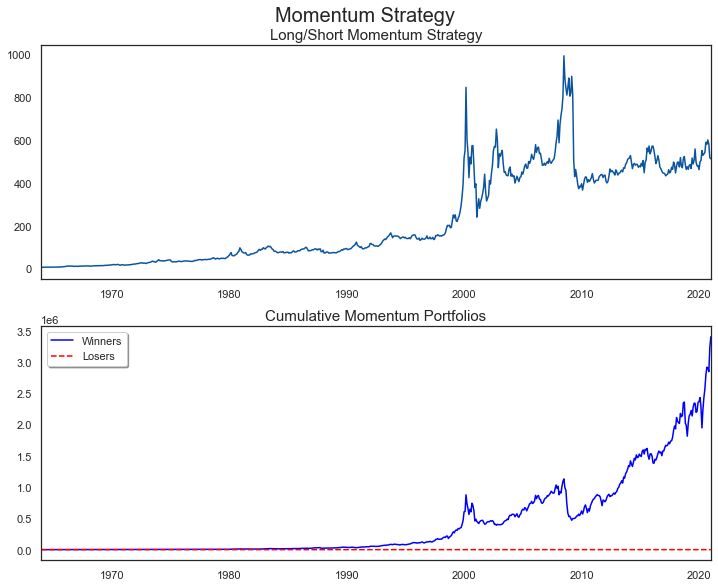

In [88]:
plt.figure(figsize=(12,9))
plt.suptitle('Momentum Strategy', fontsize=20)
ax1 = plt.subplot(211)
ax1.set_title('Long/Short Momentum Strategy', fontsize=15)
ax1.set_xlim([dt.datetime(1964,1,1), dt.datetime(2020,12,31)])
ax1.plot(ewret_t['cumret_long_short'])
ax2 = plt.subplot(212)
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15)
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--')
ax2.set_xlim([dt.datetime(1964,1,1), dt.datetime(2020,12,31)])
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)
plt.subplots_adjust(top=0.92, hspace=0.2)

### Testing with FF MOM

In [89]:
# Obtaining Fama-French MOM factors
ff_mom = pd.read_csv('FF_mom.csv', skiprows = 12, nrows=1128, index_col = 0)

# Setting monthly index
ff_mom.index = pd.to_datetime(ff_mom.index, format= '%Y%m')
ff_mom.index = ff_mom.index.to_period('M')

# Renaming column
ff_mom.rename(columns={ ff_mom.columns[0]: "mom" }, inplace = True)

In [90]:
# Set monthly index for MOM strategy
mom = ewret_t
mom.index = mom.index.to_period('M')

In [91]:
# Creating dataframe
test_df = pd.merge(mom['long_short'], ff_mom, left_index=True, right_index=True)

In [92]:
# Correlation 
test_df['long_short'].corr(test_df['mom'])

0.9231639191723368

## Creating universe for LSTM

In [93]:
universe = formation_df.rename(columns={'hdate2':'date'})
universe = universe.set_index(universe['date'], inplace=False)

In [94]:
universe = universe[['permno']] 

In [95]:
universe.groupby('date')['permno'].count().head(20)

date
1930-12-31    500
1931-01-31    500
1931-02-28    500
1931-03-31    500
1931-04-30    500
1931-05-31    500
1931-06-30    500
1931-07-31    500
1931-08-31    500
1931-09-30    500
1931-10-31    500
1931-11-30    500
1931-12-31    500
1932-01-31    500
1932-02-29    500
1932-03-31    500
1932-04-30    500
1932-05-31    500
1932-06-30    500
1932-07-31    500
Name: permno, dtype: int64

In [96]:
universe.index = universe.index.to_period('M')
universe = universe[universe.index > '1930-12']

In [97]:
universe = universe.sort_values(by=['date','permno'])

In [98]:
#Saving file as CSV for the LSTM model
universe.to_csv('universe.csv', index=True)

In [99]:
universe_filter = universe['permno'].unique()

In [100]:
universe['permno'].nunique()

3250

## Input for variable calculation

In [101]:
input_file = LSTM_input[LSTM_input['permno'].isin(universe_filter)]

In [102]:
input_file.to_csv('Input.csv', index=False)